# Example of ensemble runs


## Load MCE package and other dependencies

In [1]:
import numpy as np
import pandas as pd
from mce.util.parms_perturbed import ParmsPerturbed
from mce.util.input_rcmip import InputRcmip
from mce.core.driver import Driver
from mce.util.plot import wrap_plotspace, unicode_character
import textwrap
from netCDF4 import Dataset
from IPython.display import display
import matplotlib as mpl

## Time series plot function used in this example

In [2]:
def plot_timeseries_ensemble(dfs, labels, variables, vnames=[], **kw):
    if not vnames:
        vnames = pd.unique(
            dfs[0].index.get_level_values('variable')).tolist()
        
    qrange = kw.get('qrange', (0.17, 0.83))
    label_qrange = unicode_character('en dash').join(
        [str(100*x) for x in qrange]
    )
    
    slc_time = kw.get('slc_time', slice(None))

    kw_plotspace = {
        'col': kw.get('col', 3),
        'kw_space': kw.get('kw_space', {'wspace': 1.1}),
    }
    p1 = wrap_plotspace(len(vnames), **kw_plotspace)
    
    for n, vn in enumerate(vnames):
        ax = p1.figure.axes[n]

        for i, df in enumerate(dfs):
            df = df.loc[:, slc_time]
            label = labels[i]
            color = f'C{i}'
            df1q = df.loc[vn].quantile(qrange)
            ax.fill_between(
                df.columns.values,
                y1=df1q.loc[qrange[1]].values,
                y2=df1q.loc[qrange[0]].values,
                edgecolor='none', facecolor=color, alpha=0.33,
                label=f'{label} {label_qrange}%',
            )
            df.loc[vn].median().plot(
                ax=ax, grid=True, color=color, label=f'{label} median')

        ax.legend()
        ax.set_xlabel('Time (yr)')
        ax.set_ylabel('\n'.join(textwrap.wrap(
            '{} ({})'.format(*variables[vn]), 40
        )))

        p1.despine(ax)

    return p1

## Indicators plot function used in this example

In [3]:
def plot_indicators(df, variables, ensembles=[], vnames=[], **kw):
    if not ensembles:
        vnames = df.index.levels[1].tolist()
    if not vnames:
        vnames = df.index.levels[0].tolist()

    qvals = kw.get('qvals', [0.05, 0.17, 0.5, 0.83, 0.95])
    qvllo, qllo, qmed, qlhi, qvlhi = qvals
    col = kw.get('col', 4)
    kw_space = kw.get('kw_space', {'aspect': 0.5, 'wspace': 1.1})

    p1 = wrap_plotspace(len(vnames), col=col, kw_space=kw_space)

    xvals = np.arange(len(ensembles)) + 0.5
    kw_errorbar = {
        'fmt': 'o', 'ls': 'None',
        'elinewidth': 1.5, 'capthick': 1.5, 'capsize': 6.,
    }
    colors = [f'C{i}' for i in range(len(ensembles))]

    for n, vname in enumerate(vnames):
        vn = vname.split('@')
        ax = p1.figure.axes[n]

        for i, ensemble in enumerate(ensembles):
            d1q = df.loc[(vname, ensemble), :].quantile(qvals)
            ax.errorbar(
                [xvals[i]], [d1q[qmed]],
                yerr=[[d1q[qmed]-d1q[qllo]], [d1q[qlhi]-d1q[qmed]]],
                ecolor=colors[i], mec=colors[i], mfc=colors[i],
                **kw_errorbar
            )
            ax.plot(xvals[i], d1q[qvllo], ls='None', marker='v', color=colors[i])
            ax.plot(xvals[i], d1q[qvlhi], ls='None', marker='^', color=colors[i])

        ax.set_ylabel('\n'.join(textwrap.wrap(
            '{} ({})'.format(*variables[vn[0]]), 40
        )))
        if len(vn) > 1:
            ax.set_title('\n'.join(textwrap.wrap(vn[1], 18)))

        ax.set_xlim(xvals[0]-0.8, xvals[-1]+0.8)
        mpl.pyplot.setp(ax.get_xticklines(), visible=False)
        mpl.pyplot.setp(ax.get_xticklabels(), visible=False)
        ax.grid(axis='y')
        p1.despine(ax, bottom=True)

    # Custom legend
    Line2D = mpl.lines.Line2D
    handles = [
        Line2D([], [], ls='None', marker='^', color='k'),
        mpl.container.ErrorbarContainer(
            (
                Line2D([], [], ls='None', marker=kw_errorbar['fmt'], color='k'),
                [Line2D([], [], ls='None', color='k')],
                [mpl.collections.LineCollection(np.empty((2, 2, 2)), colors='k')],
            ),
            has_xerr=True,
        ),
        Line2D([], [], ls='None', marker='v', color='k'),
        mpl.patches.Patch(alpha=0, linewidth=0),
    ]
    char_endash = unicode_character('en dash')
    labels = [
        '{}%'.format(int(100*qvlhi+0.5)),
        'Median, {}{}{}%'.format(int(100*qllo+0.5), char_endash, int(100*qlhi+0.5)),
        '{}%'.format(int(100*qvllo+0.5)),
        'Ensemble',
    ]
    for i, ensemble in enumerate(ensembles):
        handles.append(Line2D([], [], color=colors[i]))
        labels.append(ensemble)
        
    handler_map = {
        type(handles[1]):
        mpl.legend_handler.HandlerErrorbar(xerr_size=1.),
    }
    ax.legend(
        handles, labels,
        loc='lower left', bbox_to_anchor=(1.05, 0.),
        handler_map=handler_map,
    )

    return p1

## Prepare perturbed parameter data and RCMIP input time series
Currently, perturbed parameter data is not publicly available. RCMIP data is available from the project's GitLab repository at https://gitlab.com/rcmip/rcmip

In [4]:
obj_pp = ParmsPerturbed('../untracked/parms_perturbed.nc')
input_rcmip = InputRcmip('../untracked/rcmip', 'v4-0-0')

## Contents of the perturbed parameter data

In [5]:
ncvars = obj_pp.ncf.variables
print('record size: {}'.format(len(ncvars['ensemble_member'])))
pd.DataFrame(
    [[name, v.long_name, v.units] for name, v in ncvars.items()
     if name not in ['ensemble_member']],
    columns=['name', 'long_name', 'units']
)

record size: 150000


,name,long_name,units
0,climate__alpha,Scaling parameter of CO2 forcing,W/m^2
1,climate__beta,Amplification parameter of CO2 forcing,dimensionless
2,climate__tau0,Time constant for fast response,yr
3,climate__tau1,Time constant for intermediate response,yr
4,climate__tau2,Time constant for slow response,yr
5,climate__a0,Normalized amplitude for fast response,dimensionless
6,climate__a1,Normalized amplitude for intermediate response,dimensionless
7,climate__a2,Normalized amplitude for slow response,dimensionless
8,climate__lambda,Climate feedback parameter,W/m^2/degC
9,climate__ecs,Equilibrium climate sensitivity diagnosed with...,degC


## Selected members for a CMIP compatible ensemble and a constrained ensemble for RCMIP Phase 2.
Here, arbitrary 600 members are used for each of the two ensembles, referred to as 'Prior' and 'Constrained'.
Currently, the member data files are not publicly available.

In [6]:
members_prior = pd.read_csv(
    '../untracked/parms_perturbed_members_prior.csv', index_col=0
).squeeze().tolist()[1000:1000+600]
members_constrained = pd.read_csv(
    '../untracked/parms_perturbed_members_constrained.csv',
    index_col=0
).squeeze().tolist()[-600:]
print(len(members_prior), len(members_constrained))

labels_ensemble = ['Prior', 'Constrained']

600 600


## Glance at parameter values for the first member of the prior

In [7]:
member = members_prior[0]
pd.Series(
    {name: ncvars[name][member].item() for name in ncvars
     if name not in ['ensemble_member']}
)

climate__alpha                                 5.310511
climate__beta                                  1.118321
climate__tau0                                  0.277022
climate__tau1                                  5.837079
climate__tau2                                315.506477
climate__a0                                    0.247388
climate__a1                                    0.371454
climate__a2                                    0.381158
climate__lambda                                1.228140
climate__ecs                                   2.997188
climate__ecs_reg                               3.351817
climate__tcr                                   1.875874
carbon__amp0                                   0.201582
carbon__amp1                                   0.231847
carbon__amp2                                   0.187758
carbon__amp3                                   0.278814
carbon__amp4                                   0.100000
carbon__beta                                   0

# Prepare input time series of 1%-per-year increase in CO<sub>2</sub> concentrations
One of the CMIP basic experiments labeled `1pctCO2`

In [8]:
"""
Prepare input time series for 1%-per-year CO2 concentration increase (1pctCO2)
"""
time, kw_driver = input_rcmip.get_input_cdrv(
    '1pctCO2', period=[1850, 1850+150], co2_only=True
)
display('time', time)
for k, v in kw_driver.items():
    display(k, v)

'time'

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 20

'cco2'

array([ 284.3169988 ,  287.16016879,  290.03177048,  292.93208818,
        295.86140906,  298.82002315,  301.80822338,  304.82630562,
        307.87456867,  310.95331436,  314.0628475 ,  317.20347598,
        320.37551074,  323.57926585,  326.81505851,  330.08320909,
        333.38404118,  336.71788159,  340.08506041,  343.48591101,
        346.92077012,  350.38997782,  353.8938776 ,  357.43281638,
        361.00714454,  364.61721599,  368.26338815,  371.94602203,
        375.66548225,  379.42213707,  383.21635844,  387.04852203,
        390.91900725,  394.82819732,  398.77647929,  402.76424409,
        406.79188653,  410.85980539,  414.96840345,  419.11808748,
        423.30926836,  427.54236104,  431.81778465,  436.1359625 ,
        440.49732212,  444.90229534,  449.3513183 ,  453.84483148,
        458.38327979,  462.96711259,  467.59678372,  472.27275155,
        476.99547907,  481.76543386,  486.5830882 ,  491.44891908,
        496.36340827,  501.32704235,  506.34031278,  511.40371

## Definition of units conversions
Changes in the total heat content are converted from J/spy/m<sup>2</sup> (spy=seconds per year) to ZJ

In [9]:
seconds_per_year = 3.15569e7
earth_area = 5.10e14 # m^2
conversion = [
    ('thc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
]
outform = {'conversion': conversion}

## Perform ensemble runs for the idealized CO<sub>2</sub> increase
Two sets of 600-member ensemble runs are conducted in a conentration-driven mode with the 1%-per-year increase CO<sub>2</sub> concentrations.

In [10]:
path_pkl = '../untracked/notebook/t_ensemble_runs/dfout_1pct.pkl'

df_prior_1pct = []
df_constrained_1pct = []

for dfx, members in zip(
    [df_prior_1pct, df_constrained_1pct], [members_prior, members_constrained]):
    for im in range(len(members)):
        kw_parms_all = obj_pp.get_parms_all(
            members[im], co2_only=True, yinit=1850,
            conc_pi={('CO2', 'ppm'): kw_driver['cco2'][0]},
        )
        if im == 0:
            print('Model parameters of the first member', kw_parms_all)
        kw_driver.update(kw_parms_all)
        drv = Driver(time, **kw_driver)
        df = drv.run(outform)
        df.index = pd.MultiIndex.from_product(
            [df.index, [im]], names=['variable', 'member'])
        dfx.append(df)

df_prior_1pct = pd.concat(df_prior_1pct).sort_index()
df_constrained_1pct = pd.concat(df_constrained_1pct).sort_index()
pd.to_pickle([df_prior_1pct, df_constrained_1pct], path_pkl)

Model parameters of the first member {'kw_irm': {'asj': array([0.24738799, 0.37145398, 0.38115802]), 'tauj': array([2.77021829e-01, 5.83707879e+00, 3.15506477e+02]), 'lamb': 1.2281396505121593}, 'kw_rfall': {'alpha': 5.310510856371472, 'beta': 1.1183206149837899, 'ccref': 284.31699879964185}, 'kw_ocean': {'hls': 72.75265114031953, 'hl1': 524.6495593528948, 'hl2': 882.7211418097661, 'hl3': 1113.2836402419236, 'eta1': 21.861985353500927, 'eta2': 7.672864884445813, 'eta3': 4.018606611570095, 'cco2_pi': 284.31699879964185}, 'kw_land': {'beta': 0.45540841627768774, 'fb_alpha': 0.9107456866095403}}
Model parameters of the first member {'kw_irm': {'asj': array([0.18916234, 0.55181921, 0.25901845]), 'tauj': array([3.63720869e-02, 2.95664978e+00, 1.98967746e+02]), 'lamb': 2.2347335024670816}, 'kw_rfall': {'alpha': 5.4078446538517255, 'beta': 1.1070764747921154, 'ccref': 284.31699879964185}, 'kw_ocean': {'hls': 72.75265114031953, 'hl1': 516.1114284998766, 'hl2': 760.257883481066, 'hl3': 806.4449

## Plot output time series for selected variables

/home/tsutsui/miniconda2/envs/esm/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


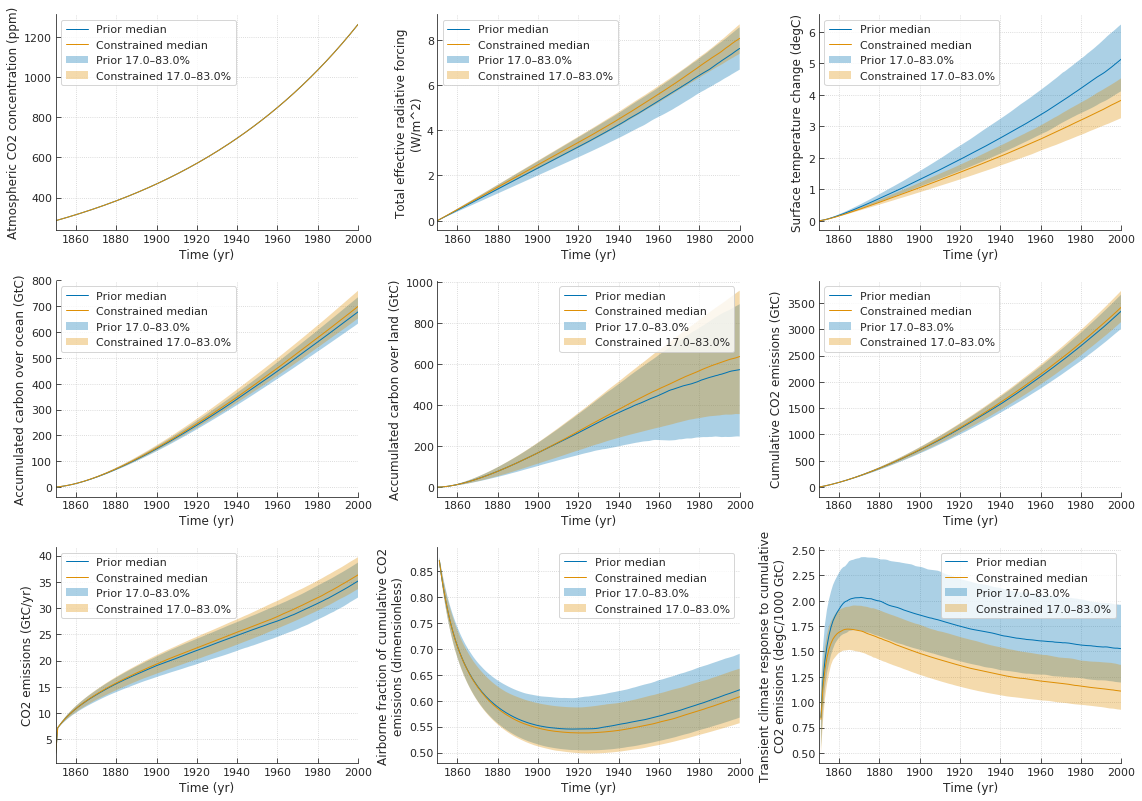

In [11]:
p1 = plot_timeseries_ensemble(
    [df_prior_1pct, df_constrained_1pct],
    labels_ensemble,
    drv.variables,
    vnames=[
        'cco2', 'erf', 'tas',
        'coct', 'cbst', 'ctot',
        'eco2', 'abf', 'tcre',
    ],
)

## Prepare input time series of a historical concentration-driven run staring from 1750

In [12]:
time, kw_driver = input_rcmip.get_input_cdrv(
    'historical', period=[1750, 2014]
)

display('time', time)
for k, v in kw_driver.items():
    display(k, v)

'time'

array([1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760,
       1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771,
       1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782,
       1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793,
       1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804,
       1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815,
       1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826,
       1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837,
       1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848,
       1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859,
       1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870,
       1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881,
       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892,
       1893, 1894, 1895, 1896, 1897, 1898, 1899, 19

'cco2'

array([277.14700317, 277.188001  , 277.22900136, 277.26300049,
       277.3040034 , 277.35100301, 277.38899994, 277.4419988 ,
       277.48900096, 277.53999837, 277.60500336, 277.66399892,
       277.73200226, 277.79599762, 277.8590037 , 277.91299947,
       277.95800018, 278.01699829, 278.0779953 , 278.13500468,
       278.1939977 , 278.27000173, 278.33399963, 278.41199493,
       278.49099986, 278.58600362, 278.68299866, 278.77399699,
       278.86599986, 278.95900218, 279.0540034 , 279.14499919,
       279.2430013 , 279.33999888, 279.43400065, 279.53200277,
       279.62900035, 279.72900136, 279.83099874, 279.93299866,
       280.03700256, 280.14099884, 280.24099731, 280.33199819,
       280.41500092, 280.49199677, 280.55499522, 280.6230011 ,
       280.68200429, 280.75299835, 280.83399709, 280.91899872,
       280.99399567, 281.0729955 , 281.15699768, 281.23399607,
       281.32200114, 281.40900167, 281.49599965, 281.56599681,
       281.64800262, 281.71799723, 281.78999837, 281.85

'df_ghg'

,,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Variable,Unit,,,,,,,,,,,,,,,,,,,,,
CH4,ppb,731.405996,731.838165,732.899974,733.634038,734.202021,734.736079,735.421000,735.893031,736.206996,736.098887,...,1783.360433,1783.421224,1788.951314,1798.419647,1802.101186,1807.850667,1813.070190,1815.261230,1822.580841,1831.470998
CO2,ppm,277.147003,277.188001,277.229001,277.263000,277.304003,277.351003,277.389000,277.441999,277.489001,277.539998,...,378.907008,381.010007,382.603020,384.739019,386.280022,388.717031,390.944021,393.015991,395.724978,397.546979
F-Gases|HFC|HFC125,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.231993,4.828963,5.509384,6.429284,7.706024,8.963194,10.464805,11.741206,13.946606,15.355008
F-Gases|HFC|HFC134a,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,36.604719,40.861658,45.316842,49.719340,52.765931,57.851537,62.847949,67.750872,74.770062,80.515729
F-Gases|HFC|HFC143a,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.881380,6.627839,7.374408,8.326616,9.355365,10.426984,11.921485,12.845085,14.522682,15.252781
F-Gases|HFC|HFC152a,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.650365,5.463510,5.803807,6.857229,7.076027,7.474034,7.894732,8.037666,8.094252,7.732658
F-Gases|HFC|HFC227ea,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.285000,0.360000,0.430000,0.500000,0.570000,0.650000,0.740000,0.830000,0.930000,1.005670
F-Gases|HFC|HFC23,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18.970015,20.050018,21.274524,22.006819,22.658214,23.296514,24.134216,24.988317,26.027622,26.890435
F-Gases|HFC|HFC236fa,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050274,0.061035,0.066376,0.074673,0.084007,0.090501,0.096682,0.111491,0.121751,0.130571


'df_erf_other'

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Variable,,,,,,,,,,,,,,,,,,,,,
Aerosols,0.000000,0.000836,0.001212,0.000801,-0.000571,0.000063,0.000618,-0.001421,-0.000764,-0.000720,...,-1.387485,-1.398719,-1.388067,-1.367507,-1.329220,-1.321976,-1.330262,-1.320120,-1.308953,-1.308580
Albedo Change,0.000000,-0.000229,-0.000459,-0.000688,-0.000918,-0.001147,-0.001377,-0.001606,-0.001836,-0.002065,...,-0.195649,-0.195983,-0.196318,-0.196653,-0.196988,-0.197322,-0.197657,-0.197992,-0.198326,-0.198661
BC on Snow,0.000000,-0.000281,-0.000378,-0.000291,0.000017,0.000016,-0.000326,0.000566,0.000257,0.000220,...,0.076119,0.077084,0.081136,0.078962,0.079160,0.085433,0.083331,0.085887,0.084253,0.086328
CH4 Oxidation Stratospheric H2O,0.000000,0.000035,0.000121,0.000180,0.000226,0.000269,0.000325,0.000363,0.000388,0.000379,...,0.065072,0.065069,0.065338,0.065800,0.065977,0.066255,0.066504,0.066606,0.066959,0.067386
Contrails and Contrail-induced Cirrus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020012,0.020250,0.020722,0.020471,0.019395,0.020269,0.020810,0.021098,0.021369,0.021474
Stratospheric Ozone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.057565,-0.056642,-0.056207,-0.055470,-0.054435,-0.053786,-0.053214,-0.052651,-0.052049,-0.051391
Tropospheric Ozone,0.000000,0.000200,0.000400,0.000600,0.000800,0.001000,0.001200,0.001400,0.001600,0.001800,...,0.332000,0.334500,0.337000,0.339500,0.342000,0.344500,0.346750,0.349000,0.351250,0.353500
Solar,0.073621,0.055275,0.025197,-0.010981,-0.045395,-0.069873,-0.077455,-0.058313,-0.006956,0.043543,...,-0.033851,-0.039857,-0.051371,-0.053851,-0.053913,-0.031761,0.002608,0.016976,0.025244,0.035135
Volcanic,0.185746,0.185757,0.185760,0.185762,0.185762,0.161491,-0.064140,0.065481,0.143707,0.171560,...,0.149808,0.124554,0.121419,0.133277,0.106684,0.137988,0.109057,0.138675,0.157672,0.139778


## Definition of custom output DataFrame
Several variables are derived from existing variables as defined with a reversed Polish notation.

In [13]:
variables = [
    'abf', 'catm', 'cbsf', 'cbst', 'cco2', 'cocf', 'coct', 'ctot',
    'eco2', 'erf', 'rtnt', 'tak', 'tas', 'tcre', 'thc',
    'erf|CH4', 'erf|CO2', 'erf|F-Gases', 'erf|Montreal Gases', 'erf|N2O',
    'erf|Aerosols', 'erf|Albedo Change', 'erf|BC on Snow',
    'erf|CH4 Oxidation Stratospheric H2O',
    'erf|Contrails and Contrail-induced Cirrus',
    'erf|Stratospheric Ozone', 'erf|Tropospheric Ozone',
    'erf|Solar', 'erf|Volcanic',
]
variables_derived = [
    # derive gmst and ohc from tas and thc by simple scaling
    ('gmst', ['tas', 1.04, '/'],
     'Surface air ocean blended temperature change', 'degC'),
    ('ohc', ['thc', 1.08, '/'],
     'Ocean heat content change', 'J/spy/m^2'), 
    ('erf|Other',
     ['erf|BC on Snow', 'erf|CH4 Oxidation Stratospheric H2O',
      '+', 'erf|Contrails and Contrail-induced Cirrus', '+'],
     'Effective radiative forcing of other factors', 'W/m^2'),
    ('erf|Natural', ['erf|Solar', 'erf|Volcanic', '+'],
     'Effective radiative forcing of natural factors', 'W/m^2'),
    ('erf|Anthropogenic', ['erf', 'erf|Natural', '-'],
     'Effective radiative forcing of anthropogenic factors', 'W/m^2'),
]
conversion = [
    ('thc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
    ('ohc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
]
outform = {
    'variables': variables,
    'variables_derived': variables_derived,
    'conversion': conversion,
}

## Perform ensemble runs for the historical period

In [14]:
path_pkl = '../untracked/notebook/t_ensemble_runs/dfout_hist1750.pkl'

df_prior_hist1750 = []
df_constrained_hist1750 = []

for dfx, members in zip(
    [df_prior_hist1750, df_constrained_hist1750],
    [members_prior, members_constrained]):
    for im in range(len(members)):
        # Ocean carbon cycle is initialized for year 1750
        # and the base year of climate forcing is set to 1750
        kw_parms_all = obj_pp.get_parms_all(
            members[im], yinit=1750,
            conc_pi=kw_driver['df_ghg'][1750].to_dict())
        if im == 0:
            print('Model parameters of the first member', kw_parms_all)
        kw_driver.update(kw_parms_all)
        drv = Driver(time, **kw_driver)
        df = drv.run(outform)
        df.index = pd.MultiIndex.from_product(
            [df.index, [im]], names=['variable', 'member'])
        dfx.append(df)

df_prior_hist1750 = pd.concat(df_prior_hist1750).sort_index()
df_constrained_hist1750 = pd.concat(df_constrained_hist1750).sort_index()
pd.to_pickle([df_prior_hist1750, df_constrained_hist1750], path_pkl)

Model parameters of the first member {'kw_irm': {'asj': array([0.24738799, 0.37145398, 0.38115802]), 'tauj': array([2.77021829e-01, 5.83707879e+00, 3.15506477e+02]), 'lamb': 1.2281396505121593}, 'kw_rfall': {'alpha': 5.310510856371472, 'beta': 1.1183206149837899, 'conc_pi': {('CH4', 'ppb'): 731.4059956868491, ('CO2', 'ppm'): 277.14700317382807, ('F-Gases|HFC|HFC125', 'ppt'): 0.0, ('F-Gases|HFC|HFC134a', 'ppt'): 0.0, ('F-Gases|HFC|HFC143a', 'ppt'): 0.0, ('F-Gases|HFC|HFC152a', 'ppt'): 0.0, ('F-Gases|HFC|HFC227ea', 'ppt'): 0.0, ('F-Gases|HFC|HFC23', 'ppt'): 0.0, ('F-Gases|HFC|HFC236fa', 'ppt'): 0.0, ('F-Gases|HFC|HFC245fa', 'ppt'): 0.0, ('F-Gases|HFC|HFC32', 'ppt'): 0.0, ('F-Gases|HFC|HFC365mfc', 'ppt'): 0.0, ('F-Gases|HFC|HFC4310mee', 'ppt'): 0.0, ('F-Gases|NF3', 'ppt'): 0.0, ('F-Gases|PFC|C2F6', 'ppt'): 0.0, ('F-Gases|PFC|C3F8', 'ppt'): 0.0, ('F-Gases|PFC|C4F10', 'ppt'): 0.0, ('F-Gases|PFC|C5F12', 'ppt'): 0.0, ('F-Gases|PFC|C6F14', 'ppt'): 0.0, ('F-Gases|PFC|C7F16', 'ppt'): 0.0, ('F-Ga

## Plot output time series for selected variables

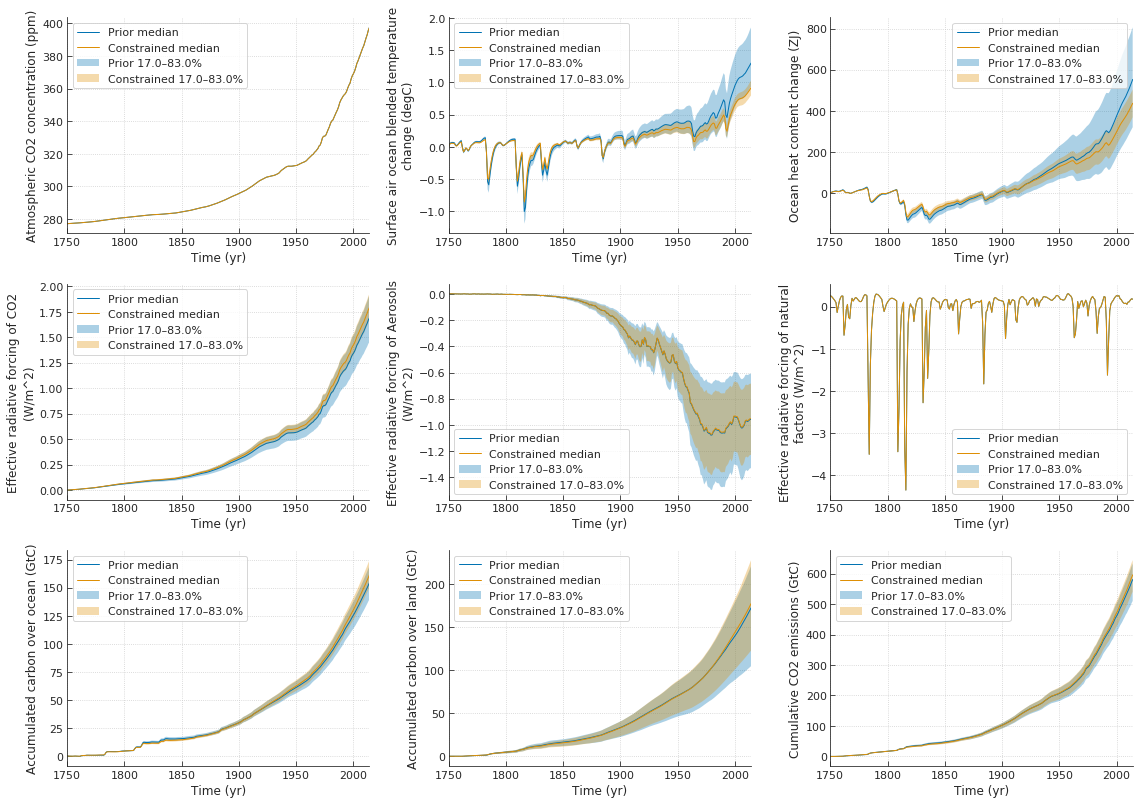

In [15]:
p1 = plot_timeseries_ensemble(
    [df_prior_hist1750, df_constrained_hist1750],
    labels_ensemble,
    drv.variables,
    vnames=[
        'cco2', 'gmst', 'ohc',
        'erf|CO2', 'erf|Aerosols', 'erf|Natural',
        'coct', 'cbst', 'ctot',
    ],
)

## Prepare input time series of a concentration-driven run for SSP2-4.5 scenario
While the base year of forcing is 1750, the input time series start from 1850.

In [16]:
# Pre-industrial concentrations in 1750 are required.
df_conc_pi = input_rcmip.get_data_series(
    'concentrations', 'historical',
    drop_elem_vname=['Atmospheric Concentrations'],
    id_vars=['Variable', 'Unit'], is_dropna=True, period=[1750, 1750],
)
display(df_conc_pi)

scenario = 'ssp245'
time, kw_driver = input_rcmip.get_input_cdrv(scenario)
display('time', time)
for k, v in kw_driver.items():
    display(k, v)

,,1750
Variable,Unit,
CH4,ppb,731.405996
CO2,ppm,277.147003
F-Gases|HFC|HFC125,ppt,0.000000
F-Gases|HFC|HFC134a,ppt,0.000000
F-Gases|HFC|HFC143a,ppt,0.000000
F-Gases|HFC|HFC152a,ppt,0.000000
F-Gases|HFC|HFC227ea,ppt,0.000000
F-Gases|HFC|HFC23,ppt,0.000000
F-Gases|HFC|HFC236fa,ppt,0.000000


'time'

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 20

'cco2'

array([284.3169988 , 284.45100403, 284.59800212, 284.73099772,
       284.84599813, 284.94099935, 285.04899343, 285.20399984,
       285.36900075, 285.54499563, 285.73899333, 285.9330012 ,
       286.10000102, 286.27100118, 286.44200134, 286.61399587,
       286.78099823, 286.95500183, 287.10500081, 287.22499847,
       287.35499827, 287.49400075, 287.66399638, 287.86000061,
       288.06099955, 288.29100291, 288.51999664, 288.75200144,
       288.9930013 , 289.22100067, 289.46999868, 289.73699697,
       290.01900228, 290.26300049, 290.51199849, 290.79699707,
       291.09999593, 291.41399892, 291.76300049, 292.11300151,
       292.45799764, 292.81599935, 293.16699982, 293.47699992,
       293.79099782, 294.07899729, 294.36499786, 294.64599864,
       294.95399984, 295.29999797, 295.67499542, 296.0069987 ,
       296.32499949, 296.65399679, 296.95399475, 297.28899638,
       297.66199748, 298.09799449, 298.51799011, 298.93599192,
       299.37699636, 299.82899221, 300.35299174, 300.90

'df_ghg'

,,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
Variable,Unit,,,,,,,,,,,,,,,,,,,,,
CH4,ppb,808.249029,808.414108,809.163132,810.404058,811.732142,813.332036,814.796122,816.452118,818.355128,820.396077,...,997.387929,997.377925,997.368932,997.358927,997.348928,997.339930,997.329926,997.319931,997.310928,997.305923
CO2,ppm,284.316999,284.451004,284.598002,284.730998,284.845998,284.940999,285.048993,285.204000,285.369001,285.544996,...,580.616999,580.446996,580.277008,580.107010,579.938004,579.768997,579.599996,579.432007,579.264002,579.180008
F-Gases|HFC|HFC125,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005060,0.004871,0.004690,0.004515,0.004347,0.004185,0.004030,0.003880,0.003735,0.003665
F-Gases|HFC|HFC134a,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F-Gases|HFC|HFC143a,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.294812,0.288167,0.281672,0.275325,0.269120,0.263055,0.257128,0.251334,0.245671,0.242872
F-Gases|HFC|HFC152a,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F-Gases|HFC|HFC227ea,ppt,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000210,0.000203,0.000197,0.000191,0.000184,0.000179,0.000173,0.000167,0.000162,0.000159
F-Gases|HFC|HFC23,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.239270,3.222720,3.206270,3.189900,3.173610,3.157410,3.141290,3.125250,3.109290,3.101340
F-Gases|HFC|HFC236fa,ppt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.596339,0.593222,0.590122,0.587039,0.583972,0.580920,0.577885,0.574866,0.571863,0.570365


'df_erf_other'

,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
Variable,,,,,,,,,,,,,,,,,,,,,
Aerosols,-0.039476,-0.038270,-0.038704,-0.040556,-0.048474,-4.791003e-02,-5.021529e-02,-5.218209e-02,-5.370057e-02,-5.644665e-02,...,-0.023369,-0.023369,-0.023369,-0.023369,-0.023369,-0.023369,-0.023369,-0.023369,-0.023369,-0.023369
Albedo Change,-0.031257,-0.031961,-0.032665,-0.033368,-0.034072,-3.477622e-02,-3.548009e-02,-3.618396e-02,-3.688782e-02,-3.759169e-02,...,-0.147469,-0.147469,-0.147469,-0.147469,-0.147469,-0.147469,-0.147469,-0.147469,-0.147469,-0.147469
BC on Snow,0.005343,0.004842,0.004627,0.004855,0.005783,5.594082e-03,5.369415e-03,6.081800e-03,6.348239e-03,6.213890e-03,...,-0.010016,-0.010016,-0.010016,-0.010016,-0.010016,-0.010016,-0.010016,-0.010016,-0.010016,-0.010016
CH4 Oxidation Stratospheric H2O,0.006061,0.006074,0.006131,0.006227,0.006328,6.450986e-03,6.563009e-03,6.689603e-03,6.834931e-03,6.990555e-03,...,0.019613,0.019612,0.019612,0.019611,0.019611,0.019610,0.019609,0.019609,0.019608,0.019608
Contrails and Contrail-induced Cirrus,0.000000,0.000000,0.000000,0.000000,0.000000,1.356368e-10,2.322624e-10,4.785243e-10,7.666280e-10,7.860864e-10,...,0.085902,0.085902,0.085902,0.085902,0.085902,0.085902,0.085902,0.085902,0.085902,0.085902
Stratospheric Ozone,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tropospheric Ozone,0.019000,0.019200,0.019400,0.019600,0.019800,2.000000e-02,2.020000e-02,2.040000e-02,2.060000e-02,2.080000e-02,...,0.038028,0.038026,0.038025,0.038023,0.038021,0.038019,0.038018,0.038016,0.038014,0.038013
Solar,-0.016441,-0.021901,-0.022712,-0.032837,-0.046690,-5.522385e-02,-5.761074e-02,-5.163571e-02,-3.477148e-02,-2.051254e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Volcanic,0.180746,0.184313,0.179540,0.015887,-0.014113,1.129486e-01,1.222556e-01,-4.482333e-02,8.628783e-02,1.535034e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Perform ensemble runs for the scenario

In [17]:
path_pkl = '../untracked/notebook/t_ensemble_runs/dfout_scenario.pkl'

df_prior_scenario = []
df_constrained_scenario = []

for dfx, members in zip(
    [df_prior_scenario, df_constrained_scenario],
    [members_prior, members_constrained]):
    for im in range(len(members)):
        # Ocean carbon cycle is initialized for year 1850
        # while the base year of climate forcing is set to 1750
        kw_parms_all = obj_pp.get_parms_all(
            members[im], yinit=1850, conc_pi=df_conc_pi[1750].to_dict())
        # In this case, pre-industrial CO2 of ocean carbon cycle needs
        # to be set explicitly to overide the value from conc_pi
        kw_parms_all['kw_ocean'].update(
            cco2_pi=kw_driver['df_ghg'].loc[('CO2', 'ppm'), 1850])
        if im == 0:
            print('Model parameters of the first member', kw_parms_all)
        kw_driver.update(kw_parms_all)
        drv = Driver(time, **kw_driver)
        df = drv.run(outform)
        df.index = pd.MultiIndex.from_product(
            [df.index, [im]], names=['variable', 'member'])
        dfx.append(df)

df_prior_scenario = pd.concat(df_prior_scenario).sort_index()
df_constrained_scenario = pd.concat(df_constrained_scenario).sort_index()
pd.to_pickle([df_prior_scenario, df_constrained_scenario], path_pkl)

Model parameters of the first member {'kw_irm': {'asj': array([0.24738799, 0.37145398, 0.38115802]), 'tauj': array([2.77021829e-01, 5.83707879e+00, 3.15506477e+02]), 'lamb': 1.2281396505121593}, 'kw_rfall': {'alpha': 5.310510856371472, 'beta': 1.1183206149837899, 'conc_pi': {('CH4', 'ppb'): 731.4059956868491, ('CO2', 'ppm'): 277.14700317382807, ('F-Gases|HFC|HFC125', 'ppt'): 0.0, ('F-Gases|HFC|HFC134a', 'ppt'): 0.0, ('F-Gases|HFC|HFC143a', 'ppt'): 0.0, ('F-Gases|HFC|HFC152a', 'ppt'): 0.0, ('F-Gases|HFC|HFC227ea', 'ppt'): 0.0, ('F-Gases|HFC|HFC23', 'ppt'): 0.0, ('F-Gases|HFC|HFC236fa', 'ppt'): 0.0, ('F-Gases|HFC|HFC245fa', 'ppt'): 0.0, ('F-Gases|HFC|HFC32', 'ppt'): 0.0, ('F-Gases|HFC|HFC365mfc', 'ppt'): 0.0, ('F-Gases|HFC|HFC4310mee', 'ppt'): 0.0, ('F-Gases|NF3', 'ppt'): 0.0, ('F-Gases|PFC|C2F6', 'ppt'): 0.0, ('F-Gases|PFC|C3F8', 'ppt'): 0.0, ('F-Gases|PFC|C4F10', 'ppt'): 0.0, ('F-Gases|PFC|C5F12', 'ppt'): 0.0, ('F-Gases|PFC|C6F14', 'ppt'): 0.0, ('F-Gases|PFC|C7F16', 'ppt'): 0.0, ('F-Ga

## Plot output time series for selected variables, focusing on the 21st century

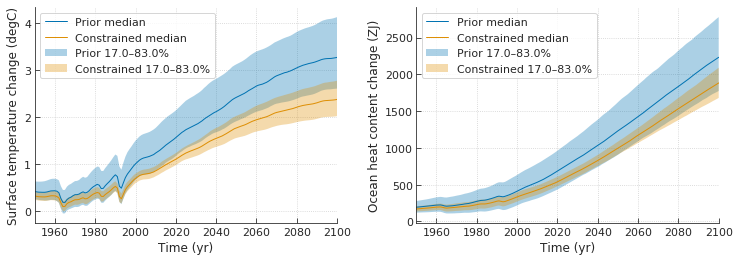

In [18]:
p1 = plot_timeseries_ensemble(
    [df_prior_scenario, df_constrained_scenario],
    labels_ensemble,
    drv.variables, vnames=['tas', 'ohc'], slc_time=slice(1950, 2100))

## Indicators from the ensemble runs

In [19]:
df_indicators = []

for members, elab in zip([members_prior, members_constrained], labels_ensemble):
    df_indicators.append(
        pd.Series(
            obj_pp.ncf.variables['climate__ecs_reg'][members]
        ).rename_axis('member').rename(tuple(['ecs', elab]))
    )

for df, elab in zip([df_prior_1pct, df_constrained_1pct], labels_ensemble):
    df_indicators.append(
        df.loc['tas', 1850+70].rename(tuple(['tcr', elab]))
    )
    df_indicators.append(
        df.loc['tcre', 1850+70].rename(tuple(['tcre', elab]))
    )
    df_indicators.append(
        df.loc['coct', 1850+70].rename(tuple(['coct@y70_1pct', elab]))
    )
    df_indicators.append(
        df.loc['coct', 1850+140].rename(tuple(['coct@y140_1pct', elab]))
    )
    df_indicators.append(
        df.loc['cbst', 1850+70].rename(tuple(['cbst@y70_1pct', elab]))
    )
    df_indicators.append(
        df.loc['cbst', 1850+140].rename(tuple(['cbst@y140_1pct', elab]))
    )

char_endash = unicode_character('en dash')

for df, elab in zip([df_prior_hist1750, df_constrained_hist1750], labels_ensemble):
    df_indicators.append(
        (
            df.loc['coct', 2011] + df.loc['cocf', 2011] * 0.5
        ).rename(tuple(['coct@{}'.format(char_endash.join(['1750', '2011'])), elab]))
    )
    df_indicators.append(
        (
            df.loc['cbst', 2011] + df.loc['cbsf', 2011] * 0.5
        ).rename(tuple(['cbst@{}'.format(char_endash.join(['1750', '2011'])), elab]))
    )
    df_indicators.append(
        (
            df.loc['ctot', 2011] + df.loc['eco2', 2011] * 0.5
        ).rename(tuple(['ctot@{}'.format(char_endash.join(['1750', '2011'])), elab]))
    )

for df, elab in zip([df_prior_scenario, df_constrained_scenario], labels_ensemble):
    df_indicators.append(
        (
            df.loc['gmst', 2000:2019].mean(axis=1)
            - df.loc['gmst', 1961:1990].mean(axis=1)
        ).rename(tuple(['gmst@{} rel. to {}'.format(
            char_endash.join(['2000', '2019']),
            char_endash.join(['1961', '1990'])), elab]))
    )
    df_indicators.append(
        (
            df.loc['ohc', 2018] - df.loc['ohc', 1971]
        ).rename(tuple(['ohc@2018 rel. to 1971', elab]))
    )
    for agent in [
        'CO2', 'CH4', 'N2O', 'F-Gases', 'Montreal Gases', 'Aerosols',
        'Stratospheric Ozone', 'Tropospheric Ozone',
    ]:
        yref = {'CO2': 2014, 'Aerosols': 2014}.get(agent, 2011)
        df_indicators.append(
            df.loc[f'erf|{agent}', yref].rename(
                tuple([f'erf|{agent}@{yref} rel. to 1750', elab])
            )
        )

df_indicators = pd.DataFrame(df_indicators)
df_indicators.index = pd.MultiIndex.from_tuples(df_indicators.index)
df_indicators = df_indicators.sort_index()

## Add variable attributes for indicator labels

In [20]:
variables = drv.variables
v1 = variables['tcre']
variables.update(
    ecs=v1._make(['Equilibrium climate sensitivity', 'degC']),
    tcr=v1._make(['Transient climate response', 'degC']),
)

## Plot indicators

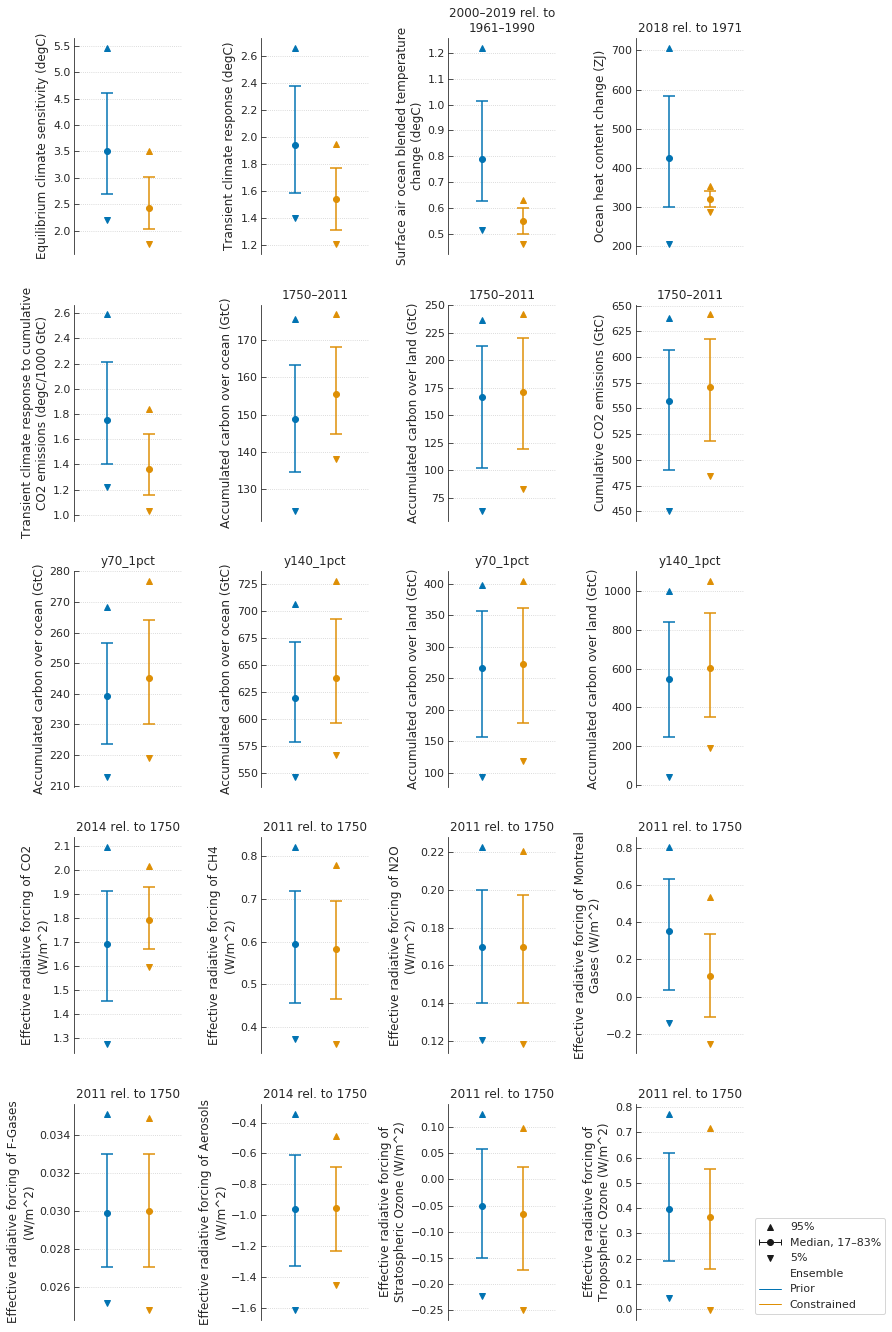

In [21]:
p1 = plot_indicators(
    df_indicators, variables,
    ensembles=['Prior', 'Constrained'],
    vnames=[
        'ecs', 'tcr',
        'gmst@2000–2019 rel. to 1961–1990',
        'ohc@2018 rel. to 1971',
        'tcre', 'coct@1750–2011', 'cbst@1750–2011', 'ctot@1750–2011',
        'coct@y70_1pct', 'coct@y140_1pct',
        'cbst@y70_1pct', 'cbst@y140_1pct',
        'erf|CO2@2014 rel. to 1750', 'erf|CH4@2011 rel. to 1750', 'erf|N2O@2011 rel. to 1750',
        'erf|Montreal Gases@2011 rel. to 1750', 'erf|F-Gases@2011 rel. to 1750',
        'erf|Aerosols@2014 rel. to 1750', 'erf|Stratospheric Ozone@2011 rel. to 1750',
        'erf|Tropospheric Ozone@2011 rel. to 1750',
    ],
)